# 模型概述

TimeGPT 是一种由 Nixtla 开发的专门用于预测任务的生成式预训练 Transformer 模型，具有自我关注机制，采用历史值窗口生成预测，添加局部位置编码，由多层编码器-解码器结构组成，每个结构都具有残差连接和层归一化。最后，线性层将解码器的输出映射到预测窗口维度。TimeGPT旨在处理不同频率和特征的时间序列，同时适应不同的输入大小和预测范围。这种适应性在很大程度上归因于TimeGPT所基于的基于transformer的底层架构。

TimeGPT可以仅使用历史值作为输入，无需训练即可对新时间序列进行准确预测（**零样本推理**）。TimeGPT在历史上最大的数据集上进行了训练，该数据集包含超过1000亿行的金融、天气、能源和网络数据，并使时间序列分析的力量大众化。该工具能够在几秒钟内辨别模式并预测未来的数据点。

TimeGPT模型“读取”时间序列数据的方式与人类读取句子的方式非常相似——从左到右。它查看过去数据的窗口，我们可以将其视为“标记”，并预测接下来会发生什么。该预测基于模型在过去数据中识别并推断未来的模式。

API为TimeGPT提供了一个接口，允许用户利用其预测功能来预测未来的事件。TimeGPT还可以用于其他与时间序列相关的任务，如假设场景、异常检测、财务预测等。

# 开始入门

## 安装

`pip install nixtlats`

## 获取Token

[官网](https://docs.nixtla.io) -> [Log in](https://dash.readme.com/to/timegpt?redirect=%2F) -> [Get Token](https://dashboard.nixtla.io/)

[查看使用额度](https://dashboard.nixtla.io/team/1247616/usage)，每次调用API都会消耗额度。

## 查看Token

In [1]:
# 我的API
my_api_key = 'nixtla-tok-G53Ikx1ijZDal0SuTfGEy8OX9tUqdcS59Psbql3gxlUYPtPUlOeLzoMIxhQPEeUaskj51dBLWWMjE3qS'

# 快速开始

## 数据准备

让我们导入一个经典的AirPassengers数据集的示例。该数据集包含了1949年至1960年间澳大利亚航空公司乘客的月度数量。首先，让我们加载数据集并绘制它：

数据的重要要求
- 确保目标变量列没有缺失或非数字值。
- 在第一个和最后一个日期戳之间不要包含日期戳的间隔/跳跃（对于给定的频率）。预测函数不会填补缺失的日期。
- 日期戳列的格式应该可以被Pandas读取。

In [7]:
import pandas as pd
df = pd.read_csv('../data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
# 激活API
from nixtla import NixtlaClient
timegpt = NixtlaClient(api_key = my_api_key)

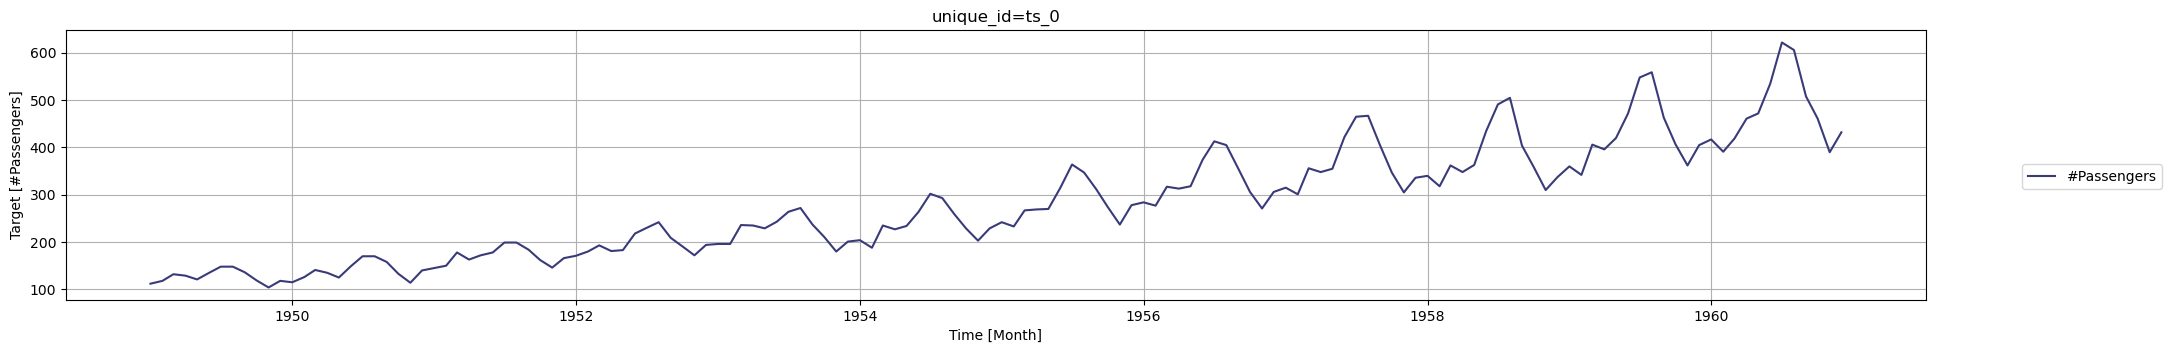

In [10]:
timegpt.plot(df, time_col='Month', target_col='#Passengers')

## 模型推理

下一步，使用SDK的forecast方法预测接下来的12个月。设置以下参数：

- df：包含时间序列数据的pandas dataframe。
- h：要预测的步数。
- freq：时间序列的频率，使用Pandas格式。参见pandas可用的[频率](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)。
- time_col：标识日期时间戳列的列。
- target_col：我们想要预测的变量。

In [11]:
timegpt_fcst_df = timegpt.forecast(df=df, h=12, freq='MS', time_col='Month', target_col='#Passengers')

# 打印预测结果的前几行
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Month,TimeGPT
0,1961-01-01,437.837921
1,1961-02-01,426.062714
2,1961-03-01,463.116547
3,1961-04-01,478.244507
4,1961-05-01,505.646484


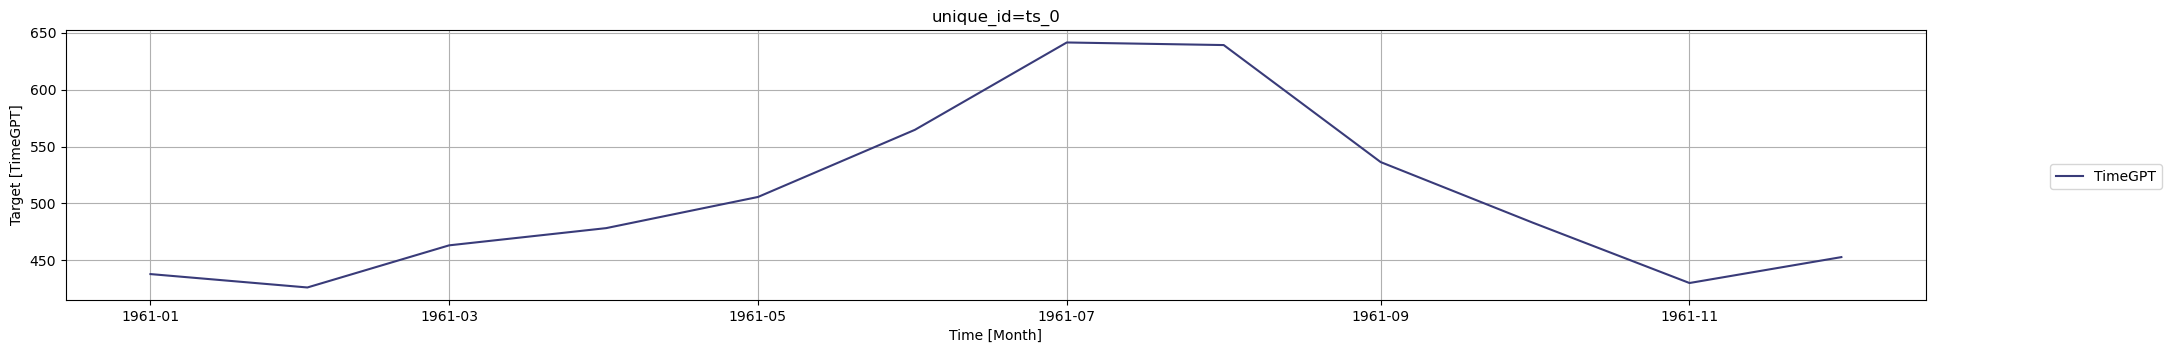

In [12]:
timegpt.plot(timegpt_fcst_df, time_col='Month', target_col='TimeGPT')

## 模型微调

微调是更多地利用 TimeGPT 的强大能力。基础模型在大量数据上进行了预训练， 捕获广泛的特征和模式。然后，这些模型可以 专门用于特定上下文或领域。通过微调， 模型的参数被细化以预测新任务，使其能够 根据需求定制其丰富的现有知识 新数据。

具体来说，微调过程包括执行某个 对输入数据进行训练迭代的次数，最大程度地减少 预测误差。

具体来说，损失函数您可以从以下选项中进行选择： - - "default","mae","mse","rmse","mape","smape"。

In [18]:
timegpt_fcst_finetune_df = timegpt.forecast(df=df, 
                                            h=12, 
                                            finetune_steps=10, 
                                            finetune_loss='mse',
                                            time_col='Month', 
                                            target_col='#Passengers')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


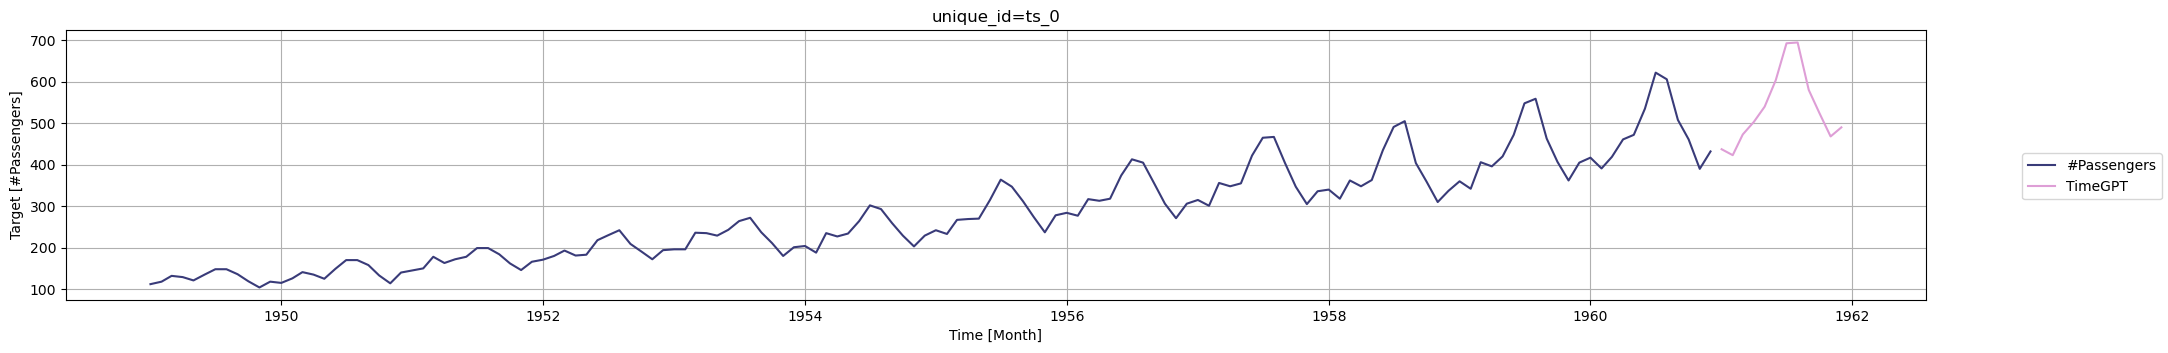

In [19]:
timegpt.plot(df, timegpt_fcst_finetune_df, time_col='Month', target_col='#Passengers')

请记住，微调可能需要一些反复试验。你可能会需要根据您的具体情况调整数量 需求和数据的复杂性。建议监视模型在微调期间的性能，并根据需要进行调整。注意 更多可能会导致更长的训练时间，如果管理不当，可能会导致过度拟合。

# 零样本推理

In [53]:
df = pd.read_csv('../data/energy.csv')
df.head()

,time,load,temp
0,2012-01-01 00:00:00,2698.0,32.00
1,2012-01-01 01:00:00,2558.0,32.67
2,2012-01-01 02:00:00,2444.0,30.00
3,2012-01-01 03:00:00,2402.0,31.00
4,2012-01-01 04:00:00,2403.0,32.00


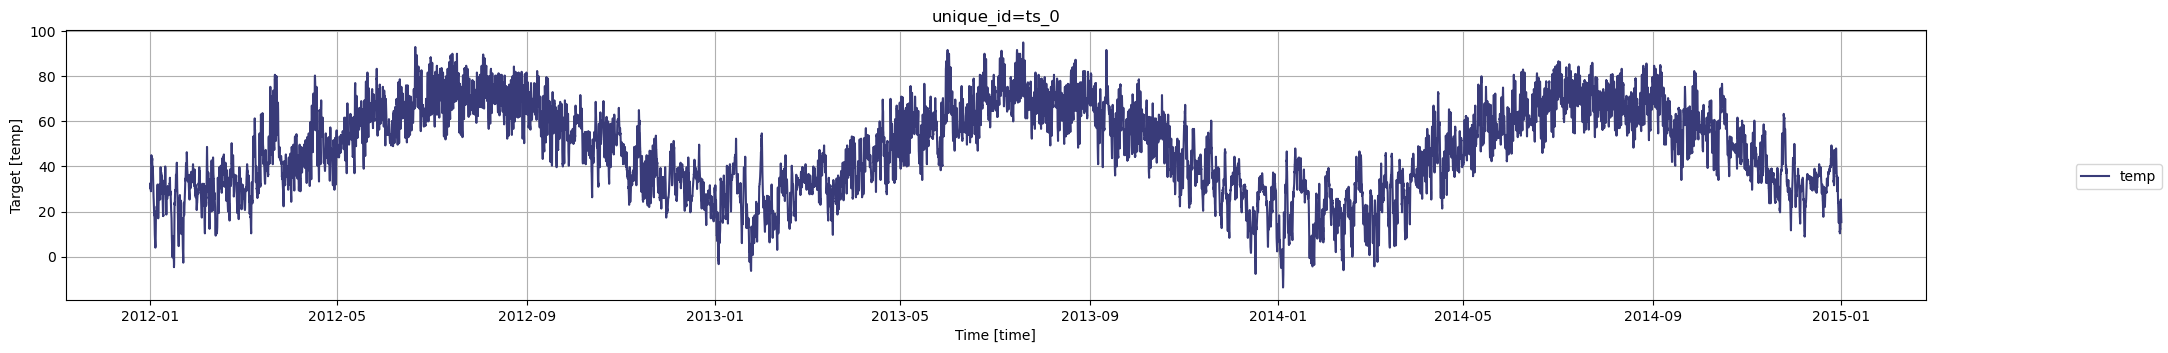

In [54]:
timegpt.plot(df, time_col='time', target_col='temp')

In [55]:
timegpt_fcst_finetune_df = timegpt.forecast(df=df, 
                                            h=12, 
                                            finetune_steps=100, 
                                            finetune_loss='mse',
                                            time_col='time', 
                                            target_col='temp')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


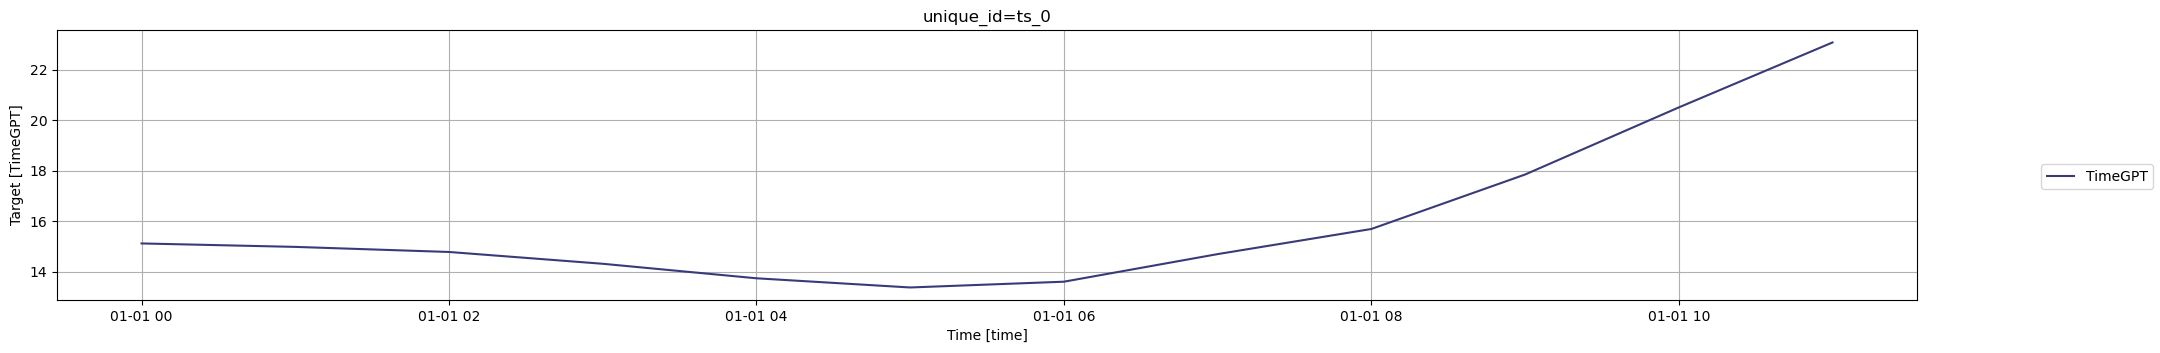

In [56]:
timegpt.plot(timegpt_fcst_finetune_df, time_col='time', target_col='TimeGPT')

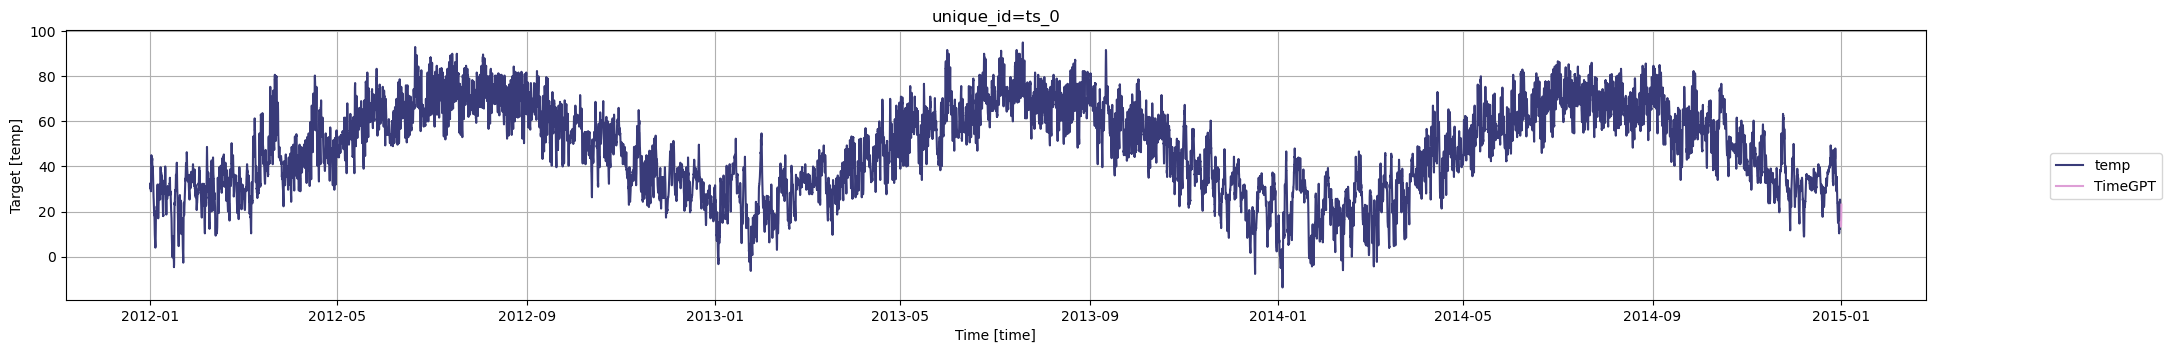

In [57]:
timegpt.plot(df, timegpt_fcst_finetune_df, time_col='time', target_col='temp')

In [58]:
timegpt_fcst_finetune_df

,time,TimeGPT
0,2015-01-01 00:00:00,15.117772
1,2015-01-01 01:00:00,14.981201
2,2015-01-01 02:00:00,14.779836
3,2015-01-01 03:00:00,14.312037
4,2015-01-01 04:00:00,13.736905
5,2015-01-01 05:00:00,13.373140
6,2015-01-01 06:00:00,13.601802
7,2015-01-01 07:00:00,14.694984
8,2015-01-01 08:00:00,15.690531
9,2015-01-01 09:00:00,17.847893
